In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date, time
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from sklearn import model_selection, preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler as SS # z-score standardization 
from sklearn.cluster import KMeans # clustering algorithm
from sklearn.decomposition import PCA # dimensionality reduction
from sklearn.metrics import silhouette_score # used as a metric to evaluate the cohesion in a cluster
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.naive_bayes import MultinomialNB
import helper # functions

# PART A

Εισαγωγή του "clinical_dataset.csv":

In [13]:
clinical = pd.read_csv('clinical_dataset.csv', delimiter=";")
clinical.head()

,part_id,fried,gender,age,hospitalization_one_year,hospitalization_three_years,ortho_hypotension,vision,audition,weight_loss,...,health_rate_comparison,pain_perception,activity_regular,smoking,alcohol_units,katz_index,iadl_grade,comorbidities_count,comorbidities_significant_count,medication_count
0,1001,Non frail,F,75,0,0,No,Sees moderately,Hears well,No,...,3 - About the same,4.2,> 2 h and < 5 h per week,Never smoked,1.0,6.0,31.0,5,0,5
1,1002,Pre-frail,M,73,0,1,No,Sees moderately,Hears moderately,No,...,2 - A little worse,3.3,> 2 h and < 5 h per week,Never smoked,14.0,6.0,26.0,12,0,4
2,1003,Pre-frail,M,72,0,0,No,Sees moderately,Hears moderately,No,...,3 - About the same,3.4,< 2 h per week,Past smoker (stopped at least 6 months),21.0,6.0,26.0,9,0,3
3,1004,Frail,F,88,0,0,No,Sees moderately,Hears moderately,No,...,3 - About the same,7.3,< 2 h per week,Never smoked,21.0,5.5,20.0,11,0,8
4,1005,Pre-frail,F,83,0,4,Yes,Sees moderately,Hears poorly,No,...,3 - About the same,3.0,> 5 h per week,Current smoker,0.0,6.0,30.0,12,0,4


In [14]:
print('The dataset contains', len(clinical), 'adults.')

The dataset contains 540 adults.


### Data Analysis


Αρχικά, θέλω να λάβω μια επισκόπηση ολόκληρου του dataset. Συγκεκριμένα θέλω να δω πόσα κατηγορικά και πόσες αριθμητικές μεταβλητές υπάρχουν, καθώς και το ποσοστό των δεδομένων που λείπουν.

Με τη χρήση δύο συναρτήσεων που ελέγχουν για τα παραπάνω δεδομένα προκύπτει ο παρακάτω heatmap.

In [15]:
# "cat" if the column is nominal features or "num" otherwise

def utils_recognize_type(clinical, col, max_cat=20):
    if (clinical[col].dtype == "O") | (clinical[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

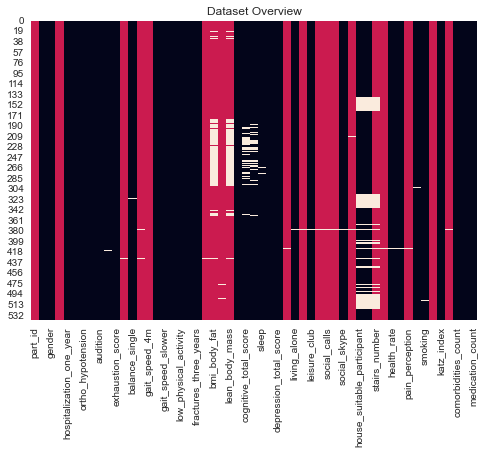

 Nominal features   Numeric   NaN 


In [16]:
dic_cols = {col:utils_recognize_type(clinical, col, max_cat=20) for col in clinical.columns}
heatmap = clinical.isnull()
for k,v in dic_cols.items():
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
        
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Nominal features ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")


Στη συνέχεια, θέλω να κοιτάξω τη κατανομή πιθανότητας της μεταβλητής «fried».

Για το λόγο αυτό χρησιμοποιώ μια γραφική παράσταση ράβδων για να κατανοήσω τη συχνότητα με την οποία υπάρχουν οι μεταβλητές «Non-frail», «Pre-frail» και «Frail» στο dataset.


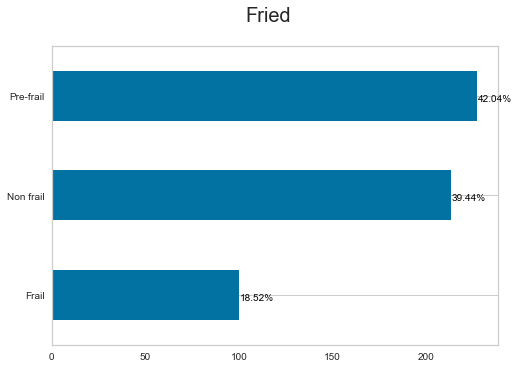

In [17]:
y = "fried"
ax = clinical[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle("Fried", fontsize=20)
plt.show()

Με βάση τα αποτελέσματα βλέπουμε ότι περίπου 400 ενήλικες είναι «Non-frail» ή «Pre-frail» και περίπου 100 είναι «Frail». Με άλλα λόγια, το ποσοστό «Frail» είναι 18,52%, το ποσοστό «Non-frail» είναι 39,44% και το «Pre-frail» είναι 42,04%.

Στη συνέχεια, με το ιστόγραμμα μπορώ να δω χονδρικά τη πυκνότητας της κατανομής της ηλικίας στο dataset και χρησιμοποιώ ένα boxplot για να ελέγξω αν υπάρχουν outliers στη μεταβλητή της ηλικίας στο dataset.


C:\Users\makic\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


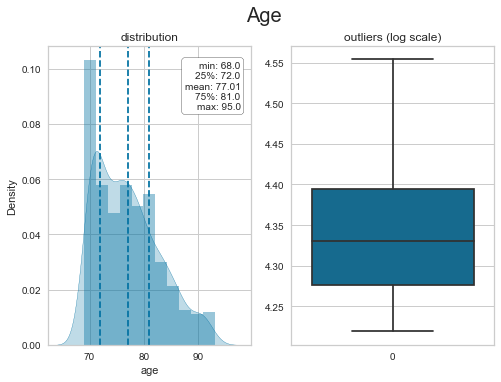

In [18]:
x = "age"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle("Age", fontsize=20)

### distribution
ax[0].title.set_text('distribution')
variable = clinical[x].fillna(clinical[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
# sns.kdeplot(variable, shade= True, ax=ax[0])
# sns.histplot(variable, kde=True, fill=True, ax=ax[0])
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = clinical[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

### boxplot 
ax[1].title.set_text('outliers (log scale)')

tmp_clinical = pd.DataFrame(clinical[x])
tmp_clinical[x] = np.log(tmp_clinical[x])
sns.boxplot(data=tmp_clinical[x], ax=ax[1])
plt.show()

Οι ενήλικες δεν είναι, κατά μέσο όρο, πολύ ηλικιωμένοι: η κατανομή είναι λοξή προς την αριστερή πλευρά (ο μέσος όρος είναι 77 ετών και το 75ο εκατοστημόριο είναι 81 ετών). Σε συνδυασμό με τα αποτελέσματα στην γραφική παράσταση του boxplot, μπορούμε να πούμε ότι δεν υπάρχουν outliers
.
Επόμενο βήμα είναι να εξετάσω το bivariate distribution για να καταλάβω αν το «Age» έχει προγνωστική δύναμη ώστε να προβλέψει το «Fried». Επομένως λειτουργώ ως εξής:
-	Διαχωρίζω τον πληθυσμό σε 3 δείγματα: το τμήμα των ενηλίκων με «Fried = Frail», «Fried = Pre-frail» και «Fried = Non-frail».
-	Σχεδιάζω και συγκρίνω τις πυκνότητες των τριών δειγμάτων. Αν οι κατανομές είναι διαφορετικές τότε η μεταβλητή είναι προγνωστική αφού οι τρεις ομάδες έχουν διαφορετικά μοτίβα.
-	Ομαδοποιώ το «Age» σε υποδείγματα (subsamples) και σχεδιάζω τη σύνθεση του δείγματος. Αν η αναλογία είναι παρόμοια σε όλα τα υποδείγματα, τότε η μεταβλητή δεν είναι προγνωστική.
-	Σχεδιάζω και συγκρίνω τα boxplots των τριών δειγμάτων για να εντοπίσω διαφορετικές συμπεριφορές σχετικά με τα outliers.


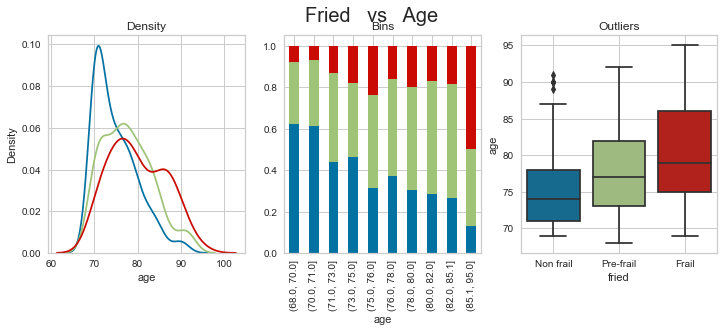

In [19]:
cat, num = "fried", "age"
fig, ax = plt.subplots( figsize=(12.0, 4.0) , nrows=1, ncols=3, sharex=False, sharey=False) 

fig.suptitle("Fried   vs   Age", fontsize=20)
            
### distribution
ax[0].title.set_text('Density')
for i in clinical[cat].unique():
    sns.kdeplot(clinical[clinical[cat]==i][num], label=i, ax=ax[0])
ax[0].grid(True)

### stacked
ax[1].title.set_text('Bins')
breaks = np.quantile(clinical[num], q=np.linspace(0,1,11))
tmp = clinical.groupby([cat, pd.cut(clinical[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[clinical[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
ax[1].grid(True)

### boxplot   
ax[2].title.set_text('Outliers')
sns.boxplot(y=num, x=cat, data=clinical, ax=ax[2])
ax[2].grid(True)
plt.show()

Με βάση τα αποτελέσματα, τα 3 plots καταλήγουν στο συμπέρασμα ότι η ηλικία είναι προγνωστικός παράγοντας. Για παράδειγμα, το ποσοστό «Frail» είναι υψηλότερο για τους ηλικιωμένους.

Προφανώς, η ηλικία των ενηλίκων βοηθάει στον προσδιορισμό της «fried» κατηγορίας τους. Αυτό είναι λογικό καθώς οι πιο ηλικιωμένοι έχουν συνήθως περισσότερα προβλήματα υγείας.


## Preprocessing of the clinical dataset ##

Αφού πλέον έχουν βγει σημαντικά συμπεράσματα σχετικά με το περιεχόμενο του dataset, συνεχίζω με το preprocessing του dataset.
Όπως είναι γνωστό το "clinical_dataset" περιέχει πληροφορίες που συλλέχθηκαν κατά την κλινική αξιολόγηση των ηλικιωμένων από ειδικούς γιατρούς. Αυτές οι πληροφορίες αντιπροσωπεύουν την κλινική κατάσταση του ηλικιωμένου σε διαφορετικούς τομείς (σωματικός, ψυχολογικός, γνωστικός κ.λπ.).

Σε αυτό το βήμα, προετοιμάζω τα raw δεδομένα για να τα καταστήσω κατάλληλα για ένα μοντέλο μηχανικής εκμάθησης.
Συγκεκριμένα πραγματοποιούνται τα παρακάτω βήματα:

- **Μετατροπή ονομαστικών χαρακτηριστικών σε αριθμητικά**: Τα ονομαστικά χαρακτηριστικά κωδικοποιούνται, που σημαίνει τη μετατροπή των ετικετών σε ακέραιους αριθμούς.
- **Κατάργηση εσφαλμένων τιμών**: Σε ορισμένες καταχωρήσεις του dataset υπάρχουν τιμές που είναι εσφαλμένες. Για τον λόγο αυτό θα αφαιρέσω αυτές τις τιμές.
- **Κλιμάκωση των δεδομένων**: Κανονικοποιώ τα δεδομένα σε ένα συγκεκριμένο εύρος για να επιταχύνω τους υπολογισμούς στον αλγόριθμο του classification.


In [20]:
clinical['fried'] = pd.factorize(clinical.fried)[0]
clinical.replace("test non realizable", np.NaN, inplace=True)
clinical.replace('Test not adequate', np.NaN, inplace=True)
clinical.replace(999, np.NaN, inplace=True)
clinical = clinical.dropna() 
clinical = clinical.drop(["gait_speed_slower","gait_optional_binary","leisure_club","living_alone",
                          "low_physical_activity","social_visits","social_calls","house_suitable_participant",
                          "social_phone","social_skype","social_text","house_suitable_professional","health_rate",
                          "stairs_number"], axis=1)

In [21]:
clinical = clinical.set_index("part_id")

# create dummy
dummy = pd.get_dummies(clinical["gender"], prefix="gender",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["activity_regular"], prefix="activity_regular",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["vision"], prefix="vision",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["audition"], prefix="audition",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["ortho_hypotension"], prefix="ortho_hypotension",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["memory_complain"], prefix="memory_complain",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["sleep"], prefix="sleep",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["health_rate_comparison"], prefix="health_rate_comparison",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["smoking"], prefix="smoking",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)
dummy = pd.get_dummies(clinical["balance_single"], prefix="balance_single",drop_first=True)
clinical= pd.concat([clinical, dummy], axis=1)

# drop the original nominal feature column
clinical = clinical.drop(["gender","activity_regular","vision","audition","ortho_hypotension",
                          "sleep", "memory_complain", "health_rate_comparison", "smoking", "balance_single",
                          "grip_strength_abnormal", "exhaustion_score","weight_loss"], axis=1)

clinical_v2 = clinical
clinical.head()

,fried,age,hospitalization_one_year,hospitalization_three_years,raise_chair_time,gait_get_up,gait_speed_4m,falls_one_year,fractures_three_years,bmi_score,...,memory_complain_Yes,sleep_Occasional sleep problem,sleep_Permanent sleep problem,health_rate_comparison_2 - A little worse,health_rate_comparison_3 - About the same,health_rate_comparison_4 - A little better,health_rate_comparison_5 - A lot better,smoking_Never smoked,smoking_Past smoker (stopped at least 6 months),balance_single_>5 sec
part_id,,,,,,,,,,,,,,,,,,,,,
1001,0,75,0,0.0,13.0,18.0,7.0,1.0,0.0,27.587326,...,0,0,0,0,1,0,0,1,0,1
1002,1,73,0,1.0,16.0,60.0,11.0,1.0,0.0,25.069362,...,0,0,0,1,0,0,0,1,0,1
1003,1,72,0,0.0,10.0,21.0,11.0,1.0,0.0,34.386317,...,0,1,0,0,1,0,0,0,1,1
1005,1,83,0,4.0,13.0,42.0,8.0,1.0,0.0,25.997436,...,1,1,0,0,1,0,0,0,0,0
1006,0,72,0,1.0,12.0,18.0,6.0,0.0,0.0,25.432526,...,0,0,0,0,1,0,0,1,0,1


Στη συνέχεια, κλιμακώνω τα χαρακτηριστικά. Συγκεκριμένα, χρησιμοποιώ το MinMax-Scaler, έτσι ώστε να επανακλιμακώσει το dataset με όλες τις τιμές χαρακτηριστικών να βρίσκονται στο ίδιο εύρος (0–2). 

In [22]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,2))
X = scaler.fit_transform(clinical.drop("fried", axis=1))

clinical_scaled = pd.DataFrame(X, columns=clinical.drop("fried", axis=1).columns, index=clinical.index)
clinical_scaled["fried"] = clinical["fried"]

clinical_scaled.head()

,age,hospitalization_one_year,hospitalization_three_years,raise_chair_time,gait_get_up,gait_speed_4m,falls_one_year,fractures_three_years,bmi_score,bmi_body_fat,...,sleep_Occasional sleep problem,sleep_Permanent sleep problem,health_rate_comparison_2 - A little worse,health_rate_comparison_3 - About the same,health_rate_comparison_4 - A little better,health_rate_comparison_5 - A lot better,smoking_Never smoked,smoking_Past smoker (stopped at least 6 months),balance_single_>5 sec,fried
part_id,,,,,,,,,,,,,,,,,,,,,
1001,0.521739,0.0,0.000000,0.402204,0.523207,0.924370,0.4,0.0,0.024651,1.003460,...,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0
1002,0.347826,0.0,0.142857,0.567493,2.000000,1.596639,0.4,0.0,0.019084,0.519031,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,1
1003,0.260870,0.0,0.000000,0.236915,0.628692,1.596639,0.4,0.0,0.039681,1.169550,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,1
1005,1.217391,0.0,0.571429,0.402204,1.367089,1.092437,0.4,0.0,0.021136,0.948097,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1
1006,0.260870,0.0,0.142857,0.347107,0.523207,0.756303,0.0,0.0,0.019887,0.519031,...,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0


## Classification ##

Χρησιμοποιώντας το προ-επεξεργασμένο clinical dataset, πραγματοποιώ ανάλυση classification για να προβλέψω την παράμετρο "fried". 

Στην ανάλυση δεν περιλαμβάνω τις 5 μετρήσεις (weight_loss, exhaustion_score, gait_speed_slower, grip_strength_abnormal, and low_physical_activity) που χρησιμοποιούνται για τη δημιουργία της κατηγοριοποίησης fried.

Διαχωρίζω το dataset σε ένα training και test σύνολο χρησιμοποιώντας τις ακόλουθες μεταβλητές:

* Το `X_train` περιέχει τα δεδομένα training για το dataset εκτός από τα χαρακτηριστικά "fried" και το "part_id". 
* Το `y_train` περιέχει τα δεδομένα training για τη στήλη "fried".
* Το `X_test` περιέχει τα δεδομένα test για το dataset εκτός από τα χαρακτηριστικά "fried" και το "part_id". 
* Το `y_test` περιέχει τα δεδομένα test για τη στήλη "fried".


In [23]:
clinical_scaled_v2 = clinical_scaled.drop("fried", axis=1)

X_train = clinical_scaled_v2.values
y_train = clinical_scaled["fried"].values

X_test = clinical_scaled_v2.values
y_test = clinical_scaled['fried'].values

#### Use of Naive Bayes algorithm for the classification. ####

In [24]:
Naive_Bayes = MultinomialNB()
Naive_Bayes.fit(X_train, y_train)
prediction_results = Naive_Bayes.predict(X_test)  

In [25]:
print('Accuracy score: ', format(accuracy_score(y_test, prediction_results)))
print('Precision score: ', format(precision_score(y_test, prediction_results,average='macro')))
print('Recall score: ', format(recall_score(y_test, prediction_results,average='macro')))
print('F1 score: ', format(f1_score(y_test, prediction_results,average='macro')))

Accuracy score:  0.734375
Precision score:  0.6912809412809412
Recall score:  0.7318679549114332
F1 score:  0.7028286559608707


# PART B

Εισαγωγή του "beacons_dataset.csv":

In [26]:
beacons = pd.read_csv('beacons_dataset.csv', delimiter=";")
beacons.head()

,part_id,ts_date,ts_time,room
0,3089,20170915,06:45:22,Kitchen
1,3089,20170915,06:45:33,Bedroom
2,3089,20170915,06:45:39,Outdoor
3,3089,20170915,06:45:53,Bedroom
4,3089,20170915,06:46:09,Outdoor


In [27]:
print('The dataset contains', len(beacons), 'beacons.')

The dataset contains 58633 beacons.


## Preprocessing of the beacons dataset ##

Το beacons dataset περιέχει πληροφορίες που καταγράφονται καθημερινά με τη χρήση έξυπνων συσκευών beacon και αφορούν την κίνηση των ηλικιωμένων στο σπίτι τους.

#### Correcting room labels and remove erroneous users: ####

In [28]:
# pd.set_option('display.max_rows', 47000)

beacons['part_id'] = pd.to_numeric(beacons['part_id'], errors='coerce')
beacons = beacons[beacons['part_id'].between(1000,9999)]
beacons.replace("Two", np.NaN, inplace=True)
beacons.replace("One", np.NaN, inplace=True)
beacons.replace("Four", np.NaN, inplace=True)
beacons.replace("three", np.NaN, inplace=True)
beacons = beacons.dropna() 
beacons['room'] = beacons['room'].str.capitalize()
beacons['room'] = beacons['room'].str.replace('\d+', '', regex=True)
beacons['room'] = beacons['room'].str.replace('\-', '', regex=True)
beacons['room'] = beacons['room'].str.replace('Leavingroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Sitingroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Kitcen', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Sittingroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Desk', 'Office')
beacons['room'] = beacons['room'].str.replace('Sittingroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Luvingroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Dinerroom', 'Dineroom')
beacons['room'] = beacons['room'].str.replace('Baghroom', 'Bathroom')
beacons['room'] = beacons['room'].str.replace('Kithen', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Kitvhen', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Kiychen', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Bedroomst', 'Bedroom')
beacons['room'] = beacons['room'].str.replace('Laundryroom', 'Laundry')
beacons['room'] = beacons['room'].str.replace('K', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Liningroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Bathroim', 'Bathroom')
beacons['room'] = beacons['room'].str.replace('Livibgroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Kitchenichen', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Bsthroom', 'Bathroom')
beacons['room'] = beacons['room'].str.replace('Seatingroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Livingroon', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Workroom', 'Office')
beacons['room'] = beacons['room'].str.replace('Kitchenitchen', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Kitchenitchenichen', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Livingroomroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Dinningroom', 'Diningroom')
beacons['room'] = beacons['room'].str.replace('Dinnerroom', 'Diningroom')
beacons['room'] = beacons['room'].str.replace('Sittingover', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Kitchenitchenitcheb', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Sittigroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Dineroom', 'Diningroom')
beacons['room'] = beacons['room'].str.replace('Leavivinroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Bqthroom', 'Bathroom')
beacons['room'] = beacons['room'].str.replace('Bathroon', 'Bathroom')
beacons['room'] = beacons['room'].str.replace('Officest', 'Office')
beacons['room'] = beacons['room'].str.replace('Ndroom', 'Bedroom')
beacons['room'] = beacons['room'].str.replace('ndroom', 'Bedroom')
beacons['room'] = beacons['room'].str.replace('Kitchenitcheb', 'Kitchen')
beacons['room'] = beacons['room'].str.replace('Living', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Livingroomroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Sittinroom', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Tv', 'T')
beacons['room'] = beacons['room'].str.replace('T', 'Livingroom')
beacons['room'] = beacons['room'].str.replace('Exithall', 'Entrance')
beacons['room'] = beacons['room'].str.replace('Ndroom', 'Bedroom')
beacons['room'] = beacons['room'].str.replace('Chambre', 'Bedroom')
beacons['room'] = beacons['room'].str.replace('Guard', 'Garden')

beacons['part_id'] = pd.to_numeric(beacons['part_id'], downcast='integer')

beacons.head()

,part_id,ts_date,ts_time,room
0,3089,20170915,06:45:22,Kitchen
1,3089,20170915,06:45:33,Bedroom
2,3089,20170915,06:45:39,Outdoor
3,3089,20170915,06:45:53,Bedroom
4,3089,20170915,06:46:09,Outdoor


Στη συνέχεια δημιουργώ ένα νέο πεδίο το οποίο δείχνει τα rows στα οποία αλλάζει η μέρα των μετρήσεων. 

In [29]:
beacons['another_day']=(~beacons['ts_date'].between(beacons['ts_date'].shift(),beacons['ts_date'].shift()) | ~beacons['part_id'].between(beacons['part_id'].shift(),beacons['part_id'].shift())).astype('bool')
beacons.head()

,part_id,ts_date,ts_time,room,another_day
0,3089,20170915,06:45:22,Kitchen,True
1,3089,20170915,06:45:33,Bedroom,False
2,3089,20170915,06:45:39,Outdoor,False
3,3089,20170915,06:45:53,Bedroom,False
4,3089,20170915,06:46:09,Outdoor,False


Στη συνέχεια μετατρέπω το πεδίο του χρόνου σε δευτερόλεπτα για να μπορέσω να υπολογίσω το ποσοστό του χρόνου που βρίσκεται το κάθε άτομο σε κάθε δωμάτιο. 

In [30]:
beacons['ts_time'] = pd.to_datetime(beacons['ts_time'])

beacons['ts_time'] = (beacons['ts_time'].dt.hour*60+beacons['ts_time'].dt.minute)*60 + beacons['ts_time'].dt.second

beacons['time_sec'] = beacons['ts_time'] - beacons['ts_time'].shift()

beacons.loc[(beacons['another_day'] == True), 'time_sec'] = 0

beacons['time_sec'] = beacons['time_sec'].shift(-1).fillna(0)
beacons['time_sec'] = pd.to_numeric(beacons['time_sec'], downcast='integer')

beacons.head()

,part_id,ts_date,ts_time,room,another_day,time_sec
0,3089,20170915,24322,Kitchen,True,11
1,3089,20170915,24333,Bedroom,False,6
2,3089,20170915,24339,Outdoor,False,14
3,3089,20170915,24353,Bedroom,False,16
4,3089,20170915,24369,Outdoor,False,14


In [31]:
print('After the preprocessing, the dataset contains', len(beacons), 'beacons.')

After the preprocessing, the dataset contains 46757 beacons.


### Generate features ###
Στο επόμενο βήμα, δημιουργείται ένα νέο dataset που έχει μία καταχώρηση για κάθε χρήστη και η κάθε καταχώριση περιέχει το ποσοστό του χρόνου που έχει περάσει το άτομο στα ακόλουθα δωμάτια «Bedroom», «Bathroom», «Livingroom» και «Kitchen». 

In [32]:
# pd.set_option('display.max_rows', 47000)

df5 = pd.DataFrame(columns = beacons['room'].unique())
df5.insert(0, "part_id", beacons['part_id'].unique(), True)
df5 = df5.fillna(0) 

# calculate the percentage
sum_time_room = beacons.groupby(['part_id', 'room'])['time_sec'].sum().reset_index()
total_room_temp = sum_time_room.groupby(['part_id'])['time_sec'].sum()
total_room = total_room_temp.to_frame(name = 'total').reset_index()
df3 = pd.merge(sum_time_room, total_room)

df3['percent_data'] = (df3['time_sec'] / df3['total']) * 100
df3['percent_data'] = pd.Series([round(val, 2) for val in df3['percent_data']], index = df3.index)

df3 = df3.drop(["time_sec", "total"], axis=1)
df3 = df3.set_index("part_id")

# keep the rooms we want and pivot the table
room_to_keep = ['Bedroom', 'Bathroom', 'Livingroom', 'Kitchen']
df3 = df3[df3.room.isin(room_to_keep)]
df3 = pd.pivot_table(df3, values='percent_data', index=['part_id'], columns=['room']).fillna(0)
df3 = pd.DataFrame(df3.to_records())

# display(df3)
df3.head()

,part_id,Bathroom,Bedroom,Kitchen,Livingroom
0,1001,2.99,10.68,12.02,27.80
1,1003,13.57,0.00,0.14,20.76
2,1005,0.00,0.00,0.00,54.30
3,1006,37.58,9.87,31.24,10.72
4,1007,1.52,22.09,42.78,22.59


In [33]:
print('The generated dataset contains', len(df3), 'entries.')

The generated dataset contains 282 entries.


## Merge datasets into one ## 
Ως τελευταίο βήμα προ-επεξεργασίας, συνδυάζω τα preprocessed clinical και beacons datasets σε ένα.

Το merged dataset περιέχει μία καταχώρηση για κάθε άτομο για το οποίο υπάρχουν τόσο κλινικά όσο και δεδομένα beacons. 

In [34]:
merged_datesets = pd.merge(left=df3, right=clinical_v2, left_on='part_id', right_on='part_id')
merged_datesets.head()

,part_id,Bathroom,Bedroom,Kitchen,Livingroom,fried,age,hospitalization_one_year,hospitalization_three_years,raise_chair_time,...,memory_complain_Yes,sleep_Occasional sleep problem,sleep_Permanent sleep problem,health_rate_comparison_2 - A little worse,health_rate_comparison_3 - About the same,health_rate_comparison_4 - A little better,health_rate_comparison_5 - A lot better,smoking_Never smoked,smoking_Past smoker (stopped at least 6 months),balance_single_>5 sec
0,1001,2.99,10.68,12.02,27.80,0,75,0,0.0,13.0,...,0,0,0,0,1,0,0,1,0,1
1,1003,13.57,0.00,0.14,20.76,1,72,0,0.0,10.0,...,0,1,0,0,1,0,0,0,1,1
2,1005,0.00,0.00,0.00,54.30,1,83,0,4.0,13.0,...,1,1,0,0,1,0,0,0,0,0
3,1006,37.58,9.87,31.24,10.72,0,72,0,1.0,12.0,...,0,0,0,0,1,0,0,1,0,1
4,1007,1.52,22.09,42.78,22.59,0,70,0,0.0,10.0,...,1,1,0,0,1,0,0,0,0,1


In [35]:
print('The merged dataset contains', len(merged_datesets), 'entries.')

The merged dataset contains 172 entries.


## Clustering ## 
Για το clustering εφαρμόζω τον αλγόριθμο K-means στο προεπεξεργασμένο dataset "merged_datasets" και αξιολογώ την ομαδοποίηση χρησιμοποιώντας το Silhouette index. 

Με βάση το silhouette score προκύπτουν τα εξής διαγράμματα:

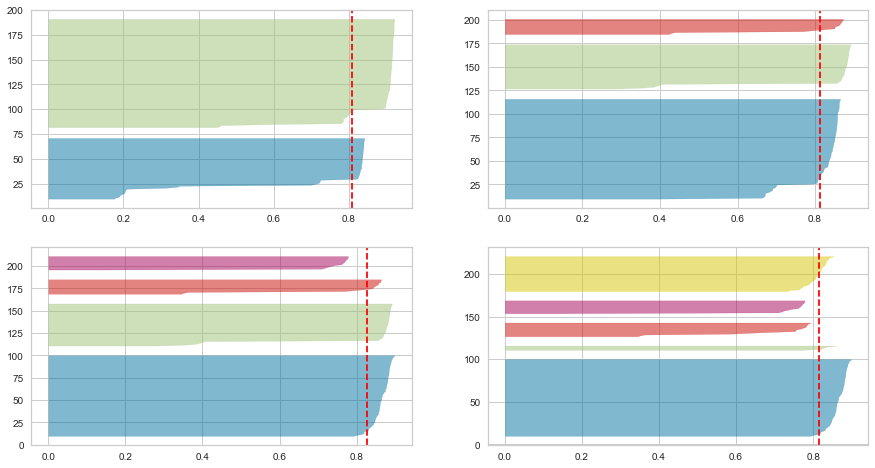

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    
    # Create KMeans instance for different number of clusters
    km = KMeans(n_clusters=i, n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(i, 2)

    #Create SilhouetteVisualizer instance with KMeans instance
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(merged_datesets)

Η κάθετη διακεκομμένη γραμμή υποδεικνύει τη μέση βαθμολογία σιλουέτας όλων των σημείων από τα δεδομένα. 

Τα silhouette plots δείχνουν ότι ένας αριθμός cluster μεταξύ δύο και τριών φαίνεται να είναι ο καταλληλότερος για το σύνολο δεδομένων. Ιδιαίτερα τα σημεία δεδομένων με n=3 συστάδες έχουν σχετικά υψηλή μέσο silhouette score (πάνω από 0,8) και τα «μαχαίρια» του cluster φαίνεται να έχουν περίπου το ίδιο μέγεθος και να μην είναι πολύ αιχμηρά, γεγονός που δείχνει ότι η συνοχή σε κάθε ομάδα δεν είναι πολύ άσχημη. 


In [37]:
km = KMeans(n_clusters=3)

# Fit the KMeans model
km.fit_predict(merged_datesets)

# Calculate Silhoutte Score
score = silhouette_score(merged_datesets, km.labels_, metric='euclidean')

# Print the score
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.812


Στη συνέχεια, εφαρμόζω το StandardScaler() του scikit-learn (z-score) για να ρίξω τον μέσο όρο των στηλών στο μηδέν περίπου και την τυπική απόκλιση στο ένα, για να λάβω υπόψη τις διαφορές μεταξύ των στηλών στο merged_datasets.

In [38]:
scaler = SS()
DNP_merged_datesets_standardized = scaler.fit_transform(merged_datesets)
merged_datesets_standardized = pd.DataFrame(DNP_merged_datesets_standardized)
merged_datesets_standardized = merged_datesets_standardized.set_index(merged_datesets.index)

Έπειτα, χρησιμοποιώ τη συνάρτηση progressiveFeatureSelection(), η οποία αναζητά χαρακτηριστικά που μπορεί να σχετίζονται με υποσύνολα χαρακτηριστικών που θα με βοηθήσουν να δομήσω τα δεδομένα.

In [39]:
selected_features = helper.progressiveFeatureSelection(merged_datesets_standardized, max_features=50, n_clusters=3)

Proposed new feature 0 with score 0.8406035950864773
Proposed new feature 1 with score 0.7869283471297768
Proposed new feature 2 with score 0.6951812328773206
Proposed new feature 3 with score 0.6125875407677298
Proposed new feature 4 with score 0.6237584073028279
Proposed new feature 5 with score 1.0
Proposed new feature 6 with score 0.6262621604368026
Proposed new feature 7 with score 0.9444333066025125
Proposed new feature 8 with score 0.9070875197958264
Proposed new feature 9 with score 0.5651156152998348
Proposed new feature 10 with score 0.6808145600568536
Proposed new feature 11 with score 0.6754366109884737
Proposed new feature 12 with score 0.9561369509043928
Proposed new feature 13 with score 0.9912790697674418
Proposed new feature 14 with score 0.5876972251636434
Proposed new feature 15 with score 0.5508180575767327
Proposed new feature 16 with score 0.5574526995136267
Proposed new feature 17 with score 0.5560782054420752
Proposed new feature 18 with score 0.7802369075320651

C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(

Proposed new feature 36 with score 0.9941860465116279
Proposed new feature 37 with score 1.0
Proposed new feature 38 with score 1.0
Proposed new feature 39 with score 1.0
Proposed new feature 40 with score 1.0
Proposed new feature 41 with score 1.0
Proposed new feature 42 with score 1.0
Proposed new feature 43 with score 1.0
Proposed new feature 44 with score 1.0


C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


Proposed new feature 45 with score 1.0


C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(

Proposed new feature 46 with score 1.0
Proposed new feature 47 with score 1.0
Proposed new feature 48 with score 1.0
Proposed new feature 49 with score 1.0
Proposed new feature 50 with score 1.0
The initial feature is 50 with a silhouette score of 1.0.
Starting selection 0...
Proposed new feature 0 with score 0.7762977680784572
Proposed new feature 1 with score 0.8256735784457264
Proposed new feature 2 with score 0.724947386379758
Proposed new feature 3 with score 0.6308838828987473
Proposed new feature 4 with score 0.5999953545981379
Proposed new feature 5 with score 0.8813779820366325
Proposed new feature 6 with score 0.5738034796136777
Proposed new feature 7 with score 0.883880184861787
Proposed new feature 8 with score 0.7885302944178868
Proposed new feature 9 with score 0.7114037154939198
Proposed new feature 10 with score 0.7430596505775635
Proposed new feature 11 with score 0.6351040873331644
Proposed new feature 12 with score 0.7944149217545492
Proposed new feature 13 with scor

Proposed new feature 9 with score 0.6508921677441489
Proposed new feature 10 with score 0.7796615879285661
Proposed new feature 11 with score 0.6379789810043445
Proposed new feature 12 with score 0.6765863777677986
Proposed new feature 13 with score 0.7087045383019984
Proposed new feature 14 with score 0.7777702061388773
Proposed new feature 15 with score 0.73325828655528
Proposed new feature 16 with score 0.5956056954044271
Proposed new feature 17 with score 0.5925430030222879
Proposed new feature 18 with score 0.6455995741008554
Proposed new feature 19 with score 0.598776580357566
Proposed new feature 20 with score 0.6088873473133521
Proposed new feature 21 with score 0.6228719749098538
Proposed new feature 22 with score 0.5271388144301411
Proposed new feature 23 with score 0.6359692782568486
Proposed new feature 24 with score 0.6043755522903878
Proposed new feature 25 with score 0.5996913662830675
Proposed new feature 26 with score 0.6670315549360415
Proposed new feature 27 with sco

Proposed new feature 22 with score 0.6756240693797725
Proposed new feature 23 with score 0.6763384489792384
Proposed new feature 24 with score 0.4422354412160178
Proposed new feature 25 with score 0.6041128539165571
Proposed new feature 26 with score 0.4349509559580924
Proposed new feature 27 with score 0.48913694472707797
Proposed new feature 28 with score 0.6071464551566071
Proposed new feature 29 with score 0.42290172486928856
Proposed new feature 30 with score 0.4633318209475424
Proposed new feature 31 with score 0.5699547073269574
Proposed new feature 32 with score 0.38149111210296893
Proposed new feature 33 with score 0.41990866632809565
Proposed new feature 34 with score 0.36988080748030644
Proposed new feature 37 with score 0.6793339353198992
Proposed new feature 39 with score 0.6798258392779314
Proposed new feature 40 with score 0.4497196592299529
Proposed new feature 41 with score 0.6800089507359194
Proposed new feature 42 with score 0.4869503336231127
Proposed new feature 43

Proposed new feature 48 with score 0.19334418000587875
Proposed new feature 49 with score 0.26236615747781294
Selected new feature 13 with score 0.5950240218957152
Starting selection 10...
Proposed new feature 0 with score 0.25346312301380336
Proposed new feature 1 with score 0.2903229617005254
Proposed new feature 2 with score 0.2918392322642033
Proposed new feature 3 with score 0.30932613778683493
Proposed new feature 4 with score 0.30260862268012717
Proposed new feature 5 with score 0.2525080710842721
Proposed new feature 6 with score 0.26720034679044097
Proposed new feature 7 with score 0.3833919380431063
Proposed new feature 9 with score 0.275401697542403
Proposed new feature 11 with score 0.5720562215640739
Proposed new feature 12 with score 0.5169155189263074
Proposed new feature 15 with score 0.5745225339201879
Proposed new feature 16 with score 0.5632139139991638
Proposed new feature 17 with score 0.5616719244535251
Proposed new feature 18 with score 0.3118482716865971
Propose

Proposed new feature 45 with score 0.16170503759162508
Proposed new feature 48 with score 0.11743453282823116
Proposed new feature 49 with score 0.5104120462818125
Selected new feature 3 with score 0.5207404530492408
Starting selection 14...
Proposed new feature 0 with score 0.16645491764194809
Proposed new feature 2 with score 0.2113758005348978
Proposed new feature 4 with score 0.20086137707056825
Proposed new feature 5 with score 0.1905676275107091
Proposed new feature 6 with score 0.21691383480900112
Proposed new feature 7 with score 0.3688645990055228
Proposed new feature 9 with score 0.2138398535692694
Proposed new feature 11 with score 0.19977721884998995
Proposed new feature 12 with score 0.5032916535482252
Proposed new feature 16 with score 0.3266488175583161
Proposed new feature 17 with score 0.12889776661644217
Proposed new feature 18 with score 0.5016005719372916
Proposed new feature 19 with score 0.11873591962555831
Proposed new feature 20 with score 0.20851739341975029
Pr

Proposed new feature 5 with score 0.07918588297606517
Proposed new feature 6 with score 0.07990704876496481
Proposed new feature 7 with score 0.21610586356493958
Proposed new feature 9 with score 0.08713487446727887
Proposed new feature 11 with score 0.14695842050427455
Proposed new feature 12 with score 0.07998074114482184
Proposed new feature 16 with score 0.07932595397190244
Proposed new feature 17 with score 0.06900604482672419
Proposed new feature 18 with score 0.08189924945627056
Proposed new feature 19 with score 0.07991963332661499
Proposed new feature 20 with score 0.11398744973503837
Proposed new feature 21 with score 0.07931484423394482
Proposed new feature 23 with score 0.07861870691088683
Proposed new feature 24 with score 0.07607684278857274
Proposed new feature 25 with score 0.13406034774424758
Proposed new feature 27 with score 0.2083132534088568
Proposed new feature 28 with score 0.08289914440092716
Proposed new feature 30 with score 0.0895743728585705
Proposed new fea

Proposed new feature 49 with score 0.07680915875257256
Selected new feature 33 with score 0.1985578528905561
Starting selection 23...
Proposed new feature 0 with score 0.0911388085162903
Proposed new feature 4 with score 0.18576478526155787
Proposed new feature 5 with score 0.11831448805165161
Proposed new feature 6 with score 0.11214216527588546
Proposed new feature 7 with score 0.10646202010703695
Proposed new feature 9 with score 0.1541618613270984
Proposed new feature 11 with score 0.05881474821973305
Proposed new feature 16 with score 0.08249029758878179
Proposed new feature 17 with score 0.08183238806996163
Proposed new feature 18 with score 0.1260717100197149
Proposed new feature 19 with score 0.1000549466759552
Proposed new feature 20 with score 0.11301601203088597
Proposed new feature 21 with score 0.07110313314362088
Proposed new feature 23 with score 0.10836211901224002
Proposed new feature 24 with score 0.15102636938126174
Proposed new feature 25 with score 0.13784000330789

Proposed new feature 34 with score 0.05211059766082504
Proposed new feature 37 with score 0.13967075544256308
Proposed new feature 41 with score 0.09674329357583228
Proposed new feature 44 with score 0.16736198600355756
Proposed new feature 45 with score 0.13226196210525804
Proposed new feature 49 with score 0.060574766733386846
Selected new feature 23 with score 0.1834874735362069
Starting selection 29...
Proposed new feature 0 with score 0.05976022261375579
Proposed new feature 5 with score 0.15844483217077981
Proposed new feature 6 with score 0.10040693513280603
Proposed new feature 9 with score 0.13812462582705695
Proposed new feature 11 with score 0.09249797585453415
Proposed new feature 16 with score 0.1021474863789666
Proposed new feature 17 with score 0.1366616694312836
Proposed new feature 18 with score 0.08627943779572832
Proposed new feature 19 with score 0.08996930284866053
Proposed new feature 20 with score 0.14724939006671575
Proposed new feature 21 with score 0.146614402

Proposed new feature 20 with score 0.12124973913729568
Proposed new feature 32 with score 0.09559428450590465
Proposed new feature 34 with score 0.11019469490395954
Proposed new feature 37 with score 0.1534278397800754
Proposed new feature 41 with score 0.15626995341546757
Proposed new feature 45 with score 0.15279238926889002
Proposed new feature 49 with score 0.03416526980375241
Selected new feature 41 with score 0.15626995341546757
Starting selection 37...
Proposed new feature 0 with score 0.04570610176742021
Proposed new feature 9 with score 0.1365534563890306
Proposed new feature 11 with score 0.07502450952042047
Proposed new feature 16 with score 0.09568605146486693
Proposed new feature 17 with score 0.1470298976519216
Proposed new feature 18 with score 0.09452458481266043
Proposed new feature 19 with score 0.1003866733371014
Proposed new feature 20 with score 0.09444554132803488
Proposed new feature 32 with score 0.14766690523816114
Proposed new feature 34 with score 0.038054905

Το συμπέρασμα στο οποίο καταλήγω μετά την εκτέλεση της παραπάνω συνάρτησης είναι ότι ο ιδανικός συνδυασμός clusters και χαρακτηριστικών είναι 3 και 50 αντίστοιχα.

Στη συνέχεια, δημιουργώ ένα νέο dataframe με αυτά τα 50 χαρακτηριστικά.

In [40]:
df_standardized_sliced = merged_datesets_standardized[selected_features]

Στο επόμενο βήμα, χρησιμοποιώ τη μέθοδο elbow που βασίζεται στη μέτρηση inertia των clusters για διαφορετικούς αριθμούς clusters, ώστε να βεβαιωθώ ότι επιλέγω τον σωστό αριθμό συστάδων για τα δεδομένα μου.

C:\Users\makic\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


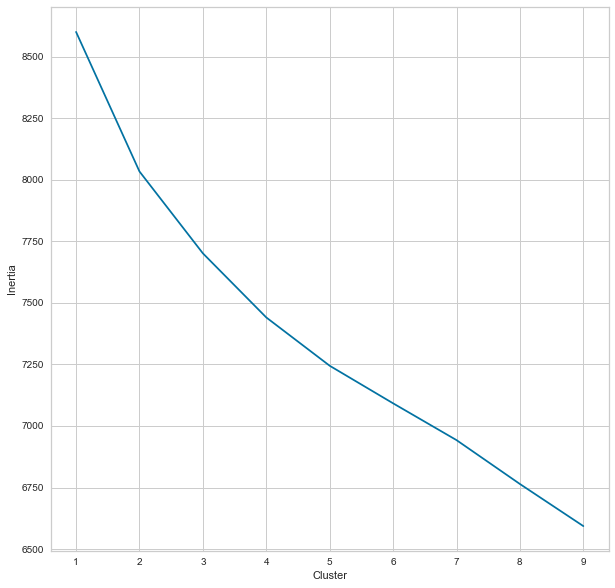

In [41]:
helper.elbowPlot(range(1,10), df_standardized_sliced)

Κοιτάζοντας το elbow plot πράγματι μας δείχνει ότι βρίσκουμε έναν “elbow” σε n=3 καθώς και n=4 clusters. Αυτό δείχνει ότι τρεις clusters μπορεί να είναι μια λογική αντιστάθμιση μεταξύ σχετικά χαμηλού inertia και όσο το δυνατόν λιγότερων clusters.

Πλέον μπορώ να εκτελέσω τον K-means για το dataset που προέκυψε με τα παραπάνω 50 χαρακτηριστικά.

Όμως, προτού εμφανίσω το αποτέλεσμα χρησιμοποιώ τη μέθοδο PCA για να μειώσω τις διαστάσεις. 

Το scatterplot που προκύπτει έπειτα απ’ όλα τα παραπάνω είναι το εξής:


<AxesSubplot:xlabel='pc_1', ylabel='pc_2'>

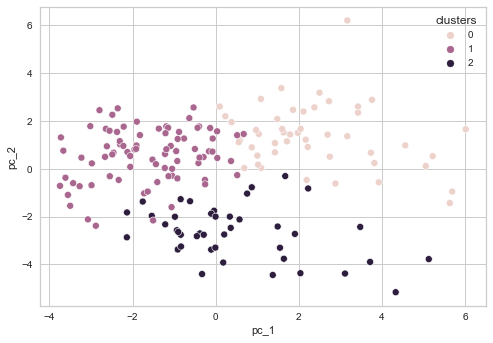

In [42]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(df_standardized_sliced)

# df_standardized_sliced["clusters"] = cluster_labels
df_standardized_sliced.loc[:, 'clusters'] = cluster_labels

# using PCA to reduce the dimensionality
pca = PCA(n_components=2, whiten=False, random_state=42)
merged_datesets_standardized_pca = pca.fit_transform(df_standardized_sliced)
merged_datesets_standardized_pca = pd.DataFrame(data=merged_datesets_standardized_pca, columns=["pc_1", "pc_2"])
merged_datesets_standardized_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=merged_datesets_standardized_pca)
